<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Feudal_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import matplotlib
from pylab import *
from IPython import display
import time
import numpy as np
from random import uniform, seed, sample, choice, shuffle, triangular

In [9]:
# Parameters

vassal_grid_size = 15  # n x n
lord_grid_size = 7
governor_grid_size = 4

initial_army_level_min, initial_army_level_max = 0.1, 0.3
initial_loyalty_value = 0.9
min_army_growth_rate, max_army_growth_rate = 0.1, 0.3

vassal_activity_value = 0.7  # [0,1] higher activity means more probability of attacking
lord_activity_value = 0.5
governor_activity_value = 0.3

loyalty_decay_rate = 0.01
times_stronger_lord = 1  # how many times the army value of a lord has to exceed the ones of his neighbours to attack
times_stronger_gov = 2
loyalty_war_boost = 0.2  # how much loyalty is gained from going to war
conquered_initial_loyalty = 0.4  # how loyal is vassal that was just conquered by a new lord
percent_of_army_lost_on_battle_attacker = 0.3
percent_of_army_lost_on_battle_defender = 0.1

In [10]:
# Classes

class Vassal:  # Vasallo

    def __init__(self, id_, initial_army_level, initial_loyalties_up, coord_x, coord_y):
        self.id_ = id_  # este es su nombre, si conquista mas feudos este se traspasa
        self.coords = (coord_x, coord_y)  # coordenadas, inmutables
        self.army_value = initial_army_level
        self.loyalties_up = initial_loyalties_up  # dict: {L1: loyalty_value1, L2: l_v2}

    def __repr__(self):
        return "Vassal{} l_u:{}".format(self.id_, self.loyalties_up)


class Lord:  # Señor

    def __init__(self, id_, initial_loyalties_up, initial_loyalties_down, last_army_value=0, last_war_vassals=[],
                 last_war_vassals_out=[]):
        self.id_ = id_
        self.loyalties_up = initial_loyalties_up  # dict: {G1: loyalty_value1, G2: l_v2}
        self.loyalties_down = initial_loyalties_down  # dict: {V1: loyalty_value1, V2: l_v2}
        self.last_war_vassals = last_war_vassals
        self.last_war_vassals_out = last_war_vassals_out
        self.last_army_value = last_army_value

    def check_state(self, vassal_nextconfig_):
        """Function to calculate army value of Lord given its loyalties down,
        also which vassals would or wouldnt go to war with him. Also calls get_neighbours and returns it"""
        all_vassals = []
        for vassal_id, loyalty in self.loyalties_down.items():
            all_vassals.append(vassal_id)
        all_vassal_coords = find_vassals_by_ids(all_vassals, vassal_nextconfig_)
        neighbours = self.get_neighbours(vassal_nextconfig_, all_vassal_coords, all_vassals)

        army_value_total = 0
        vassals_in = []
        vassals_out = []
        for x, y in all_vassal_coords:
            current_vassal = vassal_nextconfig_[x, y]
            try:
                vassal_loyalty = current_vassal.loyalties_up[self.id_]
                lord_loyalty = self.loyalties_down[current_vassal.id_]
            except KeyError:
                print("no encontramos al lord en el loyalties up de su vasallo")
            army_value_total += current_vassal.army_value * vassal_loyalty
            if uniform(0, 1) < vassal_loyalty * lord_loyalty:  # vassals will go to war depending on his loyalty
                # army_value_total += current_vassal.army_value * vassal_loyalty
                vassals_in.append(current_vassal.id_)
            else:
                vassals_out.append(current_vassal.id_)
        self.last_army_value = army_value_total  # every time army value is calculated, its saved to use in calculations
        # detail: last army value is not updated with this iterations lord conquests
        return army_value_total, list(set(vassals_in)), list(set(vassals_out)), neighbours

    def get_neighbours(self, vassal_nextconfig_, vassal_coords=None, vassal_ids=None):
        """returns attackable neighbours of lord"""
        if vassal_coords is None or vassal_ids is None:  # if params are none, gets required data
            vassal_ids = []
            for vassal_id, loyalty in self.loyalties_down.items():
                vassal_ids.append(vassal_id)
            vassal_coords = find_vassals_by_ids(vassal_ids, vassal_nextconfig_)

        neighbour_ids = []
        for x, y in vassal_coords:
            current_vassal = vassal_nextconfig_[x, y]
            cross_neighbourhood = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # not checking diagonals

            for dx, dy in cross_neighbourhood:
                try:
                    current_neighbour = vassal_nextconfig_[x + dx, y + dy]
                except IndexError:  # skip if coords out of map
                    continue
                distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (
                            current_vassal.coords[0] + current_vassal.coords[1]))
                if distance > 2:  # skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
                    continue

                if current_neighbour.id_ in vassal_ids:  # skip if neighbour is vassal of self
                    continue
                else:  # if it hasnt skipped by now, we have a neighbour cell that is other lord
                    lord_id = find_superior_of_inferior(current_neighbour)
                    neighbour_ids.append(lord_id)

        return list(set(neighbour_ids))

    def __repr__(self):
        return "Lord{} l_down:{}".format(self.id_, self.loyalties_down)


class Governor:  # Gobernador ("Rey")

    def __init__(self, id_, initial_loyalties_down):
        self.id_ = id_
        self.loyalties_down = initial_loyalties_down  # dict: {L1: loyalty_value1, L2: l_v2}
        self.last_war_lords = []  # ids of last lords who went with him to war
        self.last_war_lords_out = []  # didnt go
        self.last_army_value = 0

    def check_state(self, lord_nextconfig_, vassal_nextconfig_):
        """Function to calculate army value of Governor given its loyalties down,
        also which lords would or wouldnt go to war with him. Also calls get_neighbours and returns it"""
        all_lords = []
        for lord_id, loyalty in self.loyalties_down.items():
            all_lords.append(lord_id)
        all_lord_coords = find_lords_by_ids(all_lords, lord_nextconfig_)
        neighbours = self.get_neighbours(lord_nextconfig_, vassal_nextconfig_, all_lord_coords, all_lords)

        army_value_total = 0
        lords_in = []
        lords_out = []
        for x, y in all_lord_coords:
            current_lord = lord_nextconfig_[x, y]
            try:
                lord_loyalty = current_lord.loyalties_up[self.id_]
                gov_loyalty = self.loyalties_down[current_lord.id_]
            except KeyError:
                print("no encontramos al governor en el loyalties up de su lord")
            army_value_total += current_lord.last_army_value * lord_loyalty
            if uniform(0, 1) < lord_loyalty * gov_loyalty:  # lords will go to war depending on his loyalty
                # army_value_total += current_lord.last_army_value * lord_loyalty
                lords_in.append(current_lord.id_)
            else:
                lords_out.append(current_lord.id_)
        self.last_army_value = army_value_total  # every time army value is calculated, its saved to use in calculations
        return army_value_total, list(set(lords_in)), list(set(lords_out)), neighbours

    def get_neighbours(self, lord_nextconfig_, vassal_nextconfig_, lord_coords=None, lord_ids=None):
        """returns attackable neighbours of gov"""
        if lord_coords is None or lord_ids is None:
            lord_ids = []
            for lord_id, loyalty in self.loyalties_down.items():
                lord_ids.append(lord_id)
            lord_coords = find_lords_by_ids(lord_ids, lord_nextconfig_)

        lord_neighbour_ids = []
        for x, y in lord_coords:  # find all neighbours of lords of this gov
            current_lord = lord_nextconfig_[x, y]
            current_lord_neighbours = current_lord.get_neighbours(vassal_nextconfig_)
            lord_neighbour_ids.extend(current_lord_neighbours)

        gov_nieghbours_ids = []
        for lord_id in list(set(lord_neighbour_ids)):
            if lord_id in lord_ids:  # is also lord of self
                continue
            else:  # this lord is of enemy governor, therefore that governor is neighbour
                lord = find_lord_by_id(lord_id, lord_nextconfig_)
                gov_id = find_superior_of_inferior(lord)
                gov_nieghbours_ids.append(gov_id)

        return list(set(gov_nieghbours_ids))

    def __repr__(self):
        return "Governor{} l_down:{}".format(self.id_, self.loyalties_down)


In [11]:
#Auxiliar functions

def calculate_moraans_I(vassal_config, lord_config, governor_config):
    """
    Calculates Moraan's I for every CA level
    Moraan's I = -1 means perfectly dispersed, homogenous like chess table
    Moraan's I = 0  means totally random, no pattern
    Moraan's I = +1 means perfectly clustered, similar values are close to each other
    """
    vassal_I, lord_I, governor_I = None, None, None
    # calculate vassal I

    # get mean_x_vassal (x_barra)
    all_x_vassal = []
    for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
            vassal = vassal_config[x, y]
            loyalty_value = list(vassal.loyalties_up.values())[0]
            x_vassal = vassal.army_value * loyalty_value
            all_x_vassal.append(x_vassal)
    mean_x_vassal = sum(all_x_vassal) / len(all_x_vassal)

    all_x_vassal_values = 0  # aca esta todo el nominador (doble sumatoria)
    all_vassal_denominator = 0  # aca esta todo el denominador (sumatoria)
    for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
            current_vassal = vassal_config[x, y]
            loyalty_value = list(current_vassal.loyalties_up.values())[0]
            current_x_vassal = current_vassal.army_value * loyalty_value  # x sub i
            current_neighbours_amount = 0
            aux_x_vassals = []  # values that have to be multiplied by 1/neigh_amount

            neighbourhood = [(1, 0), (0, -1), (0, 1), (-1, 0)]  # neighbourhood doesnt allow diagonals
            for dx, dy in neighbourhood:
                # validations
                try:
                    current_neighbour = vassal_config[x + dx, y + dy]
                except IndexError:  # skip if coords out of map
                    continue
                distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (
                        current_vassal.coords[0] + current_vassal.coords[1]))
                if distance > 2:  # skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
                    continue

                # we have neighbour
                current_neighbours_amount += 1
                neighbour_loyalty_value = list(current_neighbour.loyalties_up.values())[0]
                neighbour_x_vassal = current_neighbour.army_value * neighbour_loyalty_value  # x sub j
                value = (current_x_vassal - mean_x_vassal) * (neighbour_x_vassal - mean_x_vassal)
                aux_x_vassals.append(value)

            wij = 1/current_neighbours_amount
            all_vassal_denominator += (current_x_vassal - mean_x_vassal) ** 2  # con esto tenemos el denom de un vasallo
            main_x_vassal = sum([value * wij for value in aux_x_vassals])  # con esto tenemos el nominador de un vasallo
            all_x_vassal_values += main_x_vassal

    vassal_I = all_x_vassal_values / all_vassal_denominator
    #print("VASSAL MORAAN'S I:", vassal_I)

    # calculate lord I

    # get mean_x_lord (x_barra)
    all_x_lord = []
    lords_defeated = 0
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            lord = lord_config[x, y]
            try:
                loyalty_value = list(lord.loyalties_up.values())[0]
            except IndexError:  # lord was defeated, skip to ignore in mean
                lords_defeated += 1
                continue
            x_lord = lord.last_army_value * loyalty_value
            all_x_lord.append(x_lord)
    mean_x_lord = sum(all_x_lord) / len(all_x_lord)

    all_x_lord_values = 0  # aca esta todo el nominador (doble sumatoria)
    all_lord_denominator = 0  # aca esta todo el denominador (sumatoria)
    lords_defeated_by_territory = 0
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            current_lord = lord_config[x, y]
            try:
                loyalty_value = list(current_lord.loyalties_up.values())[0]
            except IndexError:  # lord was defeated, skip
                continue
            current_x_lord = current_lord.last_army_value * loyalty_value  # x sub i
            aux_x_lords = []  # values that have to be multiplied by 1/neigh_amount

            neighbourhood = current_lord.get_neighbours(vassal_config)
            if not neighbourhood: # vassals conquered all of lord territory
                lords_defeated_by_territory += 1
                continue
            for neighbour_lord_id in neighbourhood:
                current_neighbour = find_lord_by_id(neighbour_lord_id, lord_config)
                neighbour_loyalty_value = list(current_neighbour.loyalties_up.values())[0]
                neighbour_x_lord = current_neighbour.last_army_value * neighbour_loyalty_value  # x sub j
                value = (current_x_lord - mean_x_lord) * (neighbour_x_lord - mean_x_lord)
                aux_x_lords.append(value)

            wij = 1 / len(neighbourhood)
            all_lord_denominator += (current_x_lord - mean_x_lord) ** 2  # con esto tenemos el denom de un lord
            main_x_lord = sum([value * wij for value in aux_x_lords])  # con esto tenemos el nominador de un lord
            all_x_lord_values += main_x_lord

    # lord_I = 0.99 if (lords_defeated_by_territory + lords_defeated) == lord_grid_size * lord_grid_size else "?"
    try:
        lord_I = all_x_lord_values / all_lord_denominator
    except ZeroDivisionError:
        # theres only one lord left...
        pass
    #print("LORD MORAAN'S I: {} (defeated: {}+{}={})".format(lord_I, lords_defeated, lords_defeated_by_territory,
    #                                                        lords_defeated + lords_defeated_by_territory))

    # calculate governor I

    # get mean_x_gov (x_barra)
    all_x_gov = []
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            gov = governor_config[x, y]
            x_gov = gov.last_army_value
            all_x_gov.append(x_gov)
    mean_x_gov = sum(all_x_gov) / len(all_x_gov)

    all_x_gov_values = 0  # aca esta todo el nominador (doble sumatoria)
    all_gov_denominator = 0  # aca esta todo el denominador (sumatoria)
    govs_defeated = 0
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            current_gov = governor_config[x, y]
            current_x_gov = current_gov.last_army_value  # x sub i
            aux_x_govs = []  # values that have to be multiplied by 1/neigh_amount

            neighbourhood = current_gov.get_neighbours(lord_config, vassal_config)
            if not neighbourhood:  # gov was conquered
                govs_defeated += 1
                continue
            for neighbour_gov_id in neighbourhood:
                current_neighbour = find_governor_by_id(neighbour_gov_id, governor_config)
                neighbour_x_gov = current_neighbour.last_army_value  # x sub j
                value = (current_x_gov - mean_x_gov) * (neighbour_x_gov - mean_x_gov)
                aux_x_govs.append(value)

            wij = 1 / len(neighbourhood)
            all_gov_denominator += (current_x_gov - mean_x_gov) ** 2  # con esto tenemos el denom de un gov
            main_x_gov = sum([value * wij for value in aux_x_govs])  # con esto tenemos el nominador de un gov
            all_x_gov_values += main_x_gov

    # governor_I = 0.99 if govs_defeated == governor_grid_size * governor_grid_size else "?"
    try:
        governor_I = all_x_gov_values / all_gov_denominator
    except ZeroDivisionError:
        # theres only one governor left
        pass
    #print("GOV MORAAN'S I: {} (defeated: {})".format(governor_I, govs_defeated))

    # rudimentary tests
    assert -1.2 <= vassal_I <= 1.2
    if lord_I:
        assert -1.2 <= lord_I <= 1.2
    if governor_I:
        assert -1.2 <= governor_I <= 1.2

    return vassal_I, lord_I, governor_I


def connect_down(superior, inferior, value=initial_loyalty_value):
    """Connects loyalties of superior down to inferior and vice versa."""
    superior.loyalties_down[inferior.id_] = value
    inferior.loyalties_up[superior.id_] = value


def disconnect_down(superior, inferior):
    """Disconnects superior from inferior and vice versa.
    Superior will no longer have a loyalties_down pointing to inferior.
    Inferior will no longer have a loyalties_up pointing to superior."""
    try:
        del superior.loyalties_down[inferior.id_]
    except KeyError:
        pass
    try:
        del inferior.loyalties_up[superior.id_]
    except KeyError:
        pass

    assert inferior.id_ not in superior.loyalties_down.keys()
    assert superior.id_ not in inferior.loyalties_up.keys()


def connect_all(governor_config, lord_config, vassal_config):
    """ Given a grid size, this generates random valid starting conditions
     for the loyalty connections betweeen Vassals, Lords and Governors"""

    # First, we connect vassals and lords ---

    starting_points = []
    for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
            starting_points.append((x, y))

    starting_vassal_points = sample(starting_points,
                                    k=lord_grid_size ** 2)  # takes a random sample of lord_amount points
    starting_vassal_points_aux = starting_vassal_points
    lords_of_vassals = {}  # (lord_x, lord_y): [(vassal_x, vassal_y), (vassal2_x, vassal2_y), ...]

    # every lord is connected to one random initial vassal, info is stored in dict
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            current_vassal_point = starting_vassal_points_aux.pop()
            connect_down(lord_config[x, y], vassal_config[current_vassal_point[0], current_vassal_point[1]])
            lords_of_vassals[(x, y)] = [(current_vassal_point[0], current_vassal_point[1])]

    # while amount of vassals connected != amount of all vassals
    while len([j for i in list(lords_of_vassals.values()) for j in i]) != vassal_grid_size ** 2:
        # every lord chooses one vassal, which will try to choose an unconnected vassal in its neighbourhood
        for lord_coords in lords_of_vassals.keys():
            selected_index = round(triangular(0, len(lords_of_vassals[lord_coords]) - 1, 0))
            vassal_selected_coords = lords_of_vassals[lord_coords][selected_index]
            current_vassal = vassal_config[vassal_selected_coords[0], vassal_selected_coords[1]]
            neighbourhood = [(1, 0), (0, -1), (0, 0), (0, 1), (-1, 0)]  # neighbourhood doesnt allow diagonals
            shuffle(neighbourhood)
            for dx, dy in neighbourhood:
                try:
                    current_neighbour = vassal_config[vassal_selected_coords[0] + dx, vassal_selected_coords[1] + dy]
                except IndexError:  # skip if coords out of map
                    continue

                distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (
                        current_vassal.coords[0] + current_vassal.coords[1]))
                if distance > 2:  # skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
                    continue

                if current_neighbour.id_ != current_vassal.id_:  # skip if self
                    if len(current_neighbour.loyalties_up.keys()) == 0:  # has no lord, we found unconnected neighbour
                        connect_down(lord_config[lord_coords[0], lord_coords[1]],
                                     vassal_config[vassal_selected_coords[0] + dx, vassal_selected_coords[1] + dy])
                        lords_of_vassals[(lord_coords[0], lord_coords[1])].append((vassal_selected_coords[0] + dx,
                                                                                   vassal_selected_coords[1] + dy))
                        break  # once one is found, its the turn for the next lord to choose

    # Then, we connect lords and governors ----

    starting_points = []
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            starting_points.append((x, y))

    starting_lord_points = sample(starting_points,
                                  k=governor_grid_size ** 2)  # takes a random sample of governor_amount points
    starting_lord_points_aux = starting_lord_points
    govs_of_lords = {}  # (gov_x, gov_y): [lord1_id, lord2_id, ...]

    # every gov is connected to one random initial lord, info is stored in dict
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            current_lord_point = starting_lord_points_aux.pop()
            current_lord = lord_config[current_lord_point[0], current_lord_point[1]]
            connect_down(governor_config[x, y], current_lord)
            govs_of_lords[(x, y)] = [current_lord.id_]

    # while amount of lords connected != amount of all lords
    while len([j for i in list(govs_of_lords.values()) for j in i]) != lord_grid_size ** 2:
        # every gov chooses one lord, which will try to choose an unconnected lord in its neighbourhood
        for gov_coords in govs_of_lords.keys():
            selected_index = round(triangular(0, len(govs_of_lords[gov_coords]) - 1, 0))
            # much more probable to choose lords around starting point (makes territories less spread out)
            lord_selected_id = govs_of_lords[gov_coords][selected_index]
            current_lord = find_lord_by_id(lord_selected_id, lord_config)
            neighbourhood = current_lord.get_neighbours(vassal_config)
            # we get the real neighbours, not the ones in his CA matrix
            for lord_neigh_id in neighbourhood:
                lord_neigh = find_lord_by_id(lord_neigh_id, lord_config)
                if lord_neigh_id != current_lord.id_:  # skip if self
                    if len(lord_neigh.loyalties_up.keys()) == 0:  # has no gov, we found unconnected neighbour
                        connect_down(governor_config[gov_coords[0], gov_coords[1]], lord_neigh)
                        govs_of_lords[(gov_coords[0], gov_coords[1])].append(lord_neigh_id)
                        break  # once one is found, its the turn for the next lord to choose

    # Finally, some rudimentary tests ---

    # test every vassal has one lord up
    for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
            vassal = vassal_config[x, y]
            assert len(vassal.loyalties_up.keys()) == 1

    # test every lord has at least one vassal down and exactly one governor up
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            lord = lord_config[x, y]
            assert len(lord.loyalties_up.keys()) == 1
            assert len(lord.loyalties_down.keys()) >= 1

    # test every governor has at least one lord down
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            gov = governor_config[x, y]
            assert len(gov.loyalties_down.keys()) >= 1


def print_connections(vassal_config, lord_config, governor_config):
    print("Vassal Config:")
    print(vassal_config)
    print("")
    print("Lord Config:")
    print(lord_config)
    print("")
    print("Governor Config:")
    print(governor_config)
    print("")


def find_superior_of_inferior(inferior):
    """ Given a (inferior) vassal/lord object, returns the (superior) lord/gover object.id_ connected with him """
    superior_id = list(inferior.loyalties_up.keys())[0]  # id of first superior connected, but

    if len(inferior.loyalties_up.keys()) > 1:  # if he has more than one connection, choose most loyal
        most_loyal = max(inferior.loyalties_up.values())
        for id__, value in inferior.loyalties_up.items():
            if value == most_loyal:
                superior_id = id__
                break
    return superior_id


def find_lord_of_vassal(vassal, lord_config_):
    """ Given a vassal object, returns the lord object connected with him """
    lord_id = list(vassal.loyalties_up.keys())[0]  # id of first lord connected, but

    if len(vassal.loyalties_up.keys()) > 1:  # if he has more than one connection, choose most loyal
        most_loyal = max(vassal.loyalties_up.values())
        for id__, value in vassal.loyalties_up.items():
            if value == most_loyal:
                lord_id = id__
                break

    target_lord = None
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            if lord_config_[x, y].id_ == lord_id:
                target_lord = lord_config_[x, y]
                return target_lord
    if target_lord is None:
        raise ValueError("Vassal's lord not found in lord_config")


def find_lord_by_id(id_, lord_nextconfig_):
    """ Given a id, returns the lord object of that id"""
    target_lord = None
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            if lord_nextconfig_[x, y].id_ == id_:
                target_lord = lord_nextconfig_[x, y]
                return target_lord
    if target_lord is None:
        raise ValueError("Lord not found in nextlord_config")


def find_governor_by_id(id_, governor_thisconfig):
    """ Given a id, returns the governor object of that id
    This func uses config and nextconfig"""
    target_gov = None
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            if governor_thisconfig[x, y].id_ == id_:
                target_gov = governor_thisconfig[x, y]
                return target_gov
    if target_gov is None:
        raise ValueError("Governor not found in this governor config")


def find_governor_of_vassal(vassal, governor_config_, lord_config_):
    """ Given a vassal object, returns the governor object connected with him through a lord"""
    lord = find_lord_of_vassal(vassal, lord_config_)
    governor_id = list(lord.loyalties_up.keys())[0]  # id of first governor connected # considerar mas de un gov
    target_governor = None
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            if governor_config_[x, y].id_ == governor_id:
                target_governor = governor_config_[x, y]
                return target_governor
    if target_governor is None:
        raise ValueError("Vassal's governor not found in governor_config")


def find_vassals_by_ids(vassal_id_list, vassal_nextconfig_):
    """given a list of vassal ids, returns tuple list of the
    coordinates of all vassal cells that have one of those ids"""
    vassal_coords = []
    for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
            if vassal_nextconfig_[x, y].id_ in vassal_id_list:
                vassal_coords.append((x, y))
    return vassal_coords


def find_lords_by_ids(lord_id_list, lord_nextconfig_):
    """given a list of lord ids, returns tuple list of the
    coordinates of all lord cells that have one of those ids"""
    lord_coords = []
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            if lord_nextconfig_[x, y].id_ in lord_id_list:
                lord_coords.append((x, y))
    return lord_coords


def clean_hitmap(hitmap):
    """If hitmap colision exists, will cause error because same inferior object
    will be disconnected mroe than once, leaving him no loyalties_up.
    This function removes duplicates at random, so only one attacker hits every target"""
    d1 = hitmap
    clean_hitmap_ = {}

    for k, v in d1.items():
        if v not in clean_hitmap_.values():
            clean_hitmap_[k] = v

    return clean_hitmap_


In [12]:
# backend



def initialize(pattern=1, printy=False):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig
    seed(pattern)  # if uncommented, all executions give same pattern of army values

    # initialize vassal level
    vassal_config = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {}, -1, -1)))

    ids = [num for num in range(vassal_grid_size ** 2)]
    shuffle(ids)
    for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
            initial_army_level = round(uniform(initial_army_level_min, initial_army_level_max), 10)
            new_vassal = Vassal(ids.pop(), initial_army_level, {}, x, y)
            vassal_config[x, y] = new_vassal

    vassal_nextconfig = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {}, -1, -1)))

    # initialize lord level
    lord_config = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    id_counter = 1
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            new_lord = Lord(id_counter, {}, {})
            lord_config[x, y] = new_lord
            id_counter += 1

    lord_nextconfig = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    # initialize governor level
    governor_config = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    id_counter = 1
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            new_governor = Governor(id_counter, {})
            governor_config[x, y] = new_governor
            id_counter += 1

    governor_nextconfig = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    # connect all levels (random initial condition))
    connect_all(governor_config, lord_config, vassal_config)

    # # connect all levels (deterministic initial condition)
    # # connect govs
    # # 1st gov
    # connect_down(governor_config[0, 0], lord_config[0, 0])
    # connect_down(governor_config[0, 0], lord_config[1, 0])
    # # 2nd gov
    # connect_down(governor_config[0, 1], lord_config[0, 1])
    # connect_down(governor_config[0, 1], lord_config[0, 2])
    # # 3rd gov
    # connect_down(governor_config[1, 0], lord_config[1, 1])
    # connect_down(governor_config[1, 0], lord_config[1, 2])
    # connect_down(governor_config[1, 0], lord_config[2, 2])
    # # 4th gov
    # connect_down(governor_config[1, 1], lord_config[2, 0])
    # connect_down(governor_config[1, 1], lord_config[2, 1])
    #
    # # connect lords
    # # 1st lord
    # connect_down(lord_config[0, 0], vassal_config[0, 0])
    # connect_down(lord_config[0, 0], vassal_config[1, 0])
    # connect_down(lord_config[0, 0], vassal_config[0, 1])
    # # 2do lord
    # connect_down(lord_config[0, 1], vassal_config[0, 2])
    # connect_down(lord_config[0, 1], vassal_config[1, 2])
    # connect_down(lord_config[0, 1], vassal_config[0, 3])
    # # 3rd lord
    # connect_down(lord_config[0, 2], vassal_config[1, 3])
    # connect_down(lord_config[0, 2], vassal_config[0, 4])
    # connect_down(lord_config[0, 2], vassal_config[1, 4])
    # connect_down(lord_config[0, 2], vassal_config[2, 4])
    # # 4th lord
    # connect_down(lord_config[1, 0], vassal_config[2, 0])
    # connect_down(lord_config[1, 0], vassal_config[1, 1])
    # connect_down(lord_config[1, 0], vassal_config[2, 1])
    # # 5th lord
    # connect_down(lord_config[1, 1], vassal_config[2, 2])
    # connect_down(lord_config[1, 1], vassal_config[3, 2])
    # connect_down(lord_config[1, 1], vassal_config[2, 3])
    # # 6th lord
    # connect_down(lord_config[1, 2], vassal_config[3, 3])
    # connect_down(lord_config[1, 2], vassal_config[3, 4])
    # connect_down(lord_config[1, 2], vassal_config[4, 4])
    # # 7th lord
    # connect_down(lord_config[2, 0], vassal_config[3, 0])
    # connect_down(lord_config[2, 0], vassal_config[4, 0])
    # # 8th lord
    # connect_down(lord_config[2, 1], vassal_config[3, 1])
    # connect_down(lord_config[2, 1], vassal_config[4, 1])
    # # 9th lord
    # connect_down(lord_config[2, 2], vassal_config[4, 2])
    # connect_down(lord_config[2, 2], vassal_config[4, 3])

    if printy:
        print_connections(vassal_config, lord_config, governor_config)


def observe(ca_level, color_map):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig
    cla()
    # color normalization parameters
    min_range = 1
    max_range = vassal_grid_size * vassal_grid_size

    if ca_level == "vassal":  # plot vassal level
        aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
        for x in range(vassal_grid_size):
            for y in range(vassal_grid_size):
                aux_config[x, y] = vassal_config[x, y].id_  # cambia instancia por id

    if ca_level == "lord":  # plot lord level
        aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
        for x in range(vassal_grid_size):
            for y in range(vassal_grid_size):
                # cambia instancia de vassal por id del primer lord conectado
                # normalizamos para usar toda la escala de colores
                lord_id = find_lord_of_vassal(vassal_config[x, y], lord_config).id_
                min_data = 1
                max_data = lord_grid_size * lord_grid_size
                normalized_id = (((lord_id - min_data) * (max_range - min_range)) / (max_data - min_data)) + min_range
                aux_config[x, y] = normalized_id

    if ca_level == "governor":  # plot governor level
        aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
        for x in range(vassal_grid_size):
            for y in range(vassal_grid_size):
                # cambia instancia de vassal por id del primer gov conectado
                # normalizamos para usar toda la escala de colores
                min_data = 1
                max_data = governor_grid_size * governor_grid_size
                gov_id = find_governor_of_vassal(vassal_config[x, y], governor_config, lord_config).id_
                normalized_id = (((gov_id - min_data) * (max_range - min_range)) / (max_data - min_data)) + min_range
                aux_config[x, y] = normalized_id

    imshow(aux_config, vmin=min_range, vmax=max_range, cmap=color_map)
    # print_connections(vassal_config, lord_config, governor_config)


def update(printy=False):
    """ First we update army_value and loyalties for all vassals/lords/govs,
    then we generate actions according to rules and implement their consequences"""
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig

    # iterate through VASSAL grid
    vassal_hitmap = {}  # {attacker_coords: target_coords}
    for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
            # update grid with new values
            current_vassal = vassal_config[x, y]
            growth_factor = 1 + uniform(min_army_growth_rate, max_army_growth_rate)  # in each step army value grows
            updated_army_value = round(current_vassal.army_value * growth_factor, 10)
            updated_loyalties = {k: v * (1 - loyalty_decay_rate) for k, v in
                                 current_vassal.loyalties_up.items()}  # in each step loyalty decays
            vassal_nextconfig[x, y] = Vassal(current_vassal.id_, updated_army_value, updated_loyalties, x, y)
            current_vassal = vassal_nextconfig[x, y]

            if uniform(0, 1) > vassal_activity_value:  # some chance to skip vassal
                continue

            # iterate through neighbourhood
            neighbours_army_values = {}  # coords: value
            aux_army_values = {}  # id: value, es para sumar los del mismo id
            neighbourhood = [(1, 0), (0, -1), (0, 1), (-1, 0)]  # neighbourhood doesnt allow diagonals
            for dx, dy in neighbourhood:
                try:
                    current_neighbour = vassal_config[x + dx, y + dy]
                except IndexError:  # skip if coords out of map
                    continue

                distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (
                            current_vassal.coords[0] + current_vassal.coords[1]))
                if distance > 2:  # skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
                    continue

                if current_neighbour.id_ != current_vassal.id_:  # skip if self
                    try:
                        neighbours_army_values[current_neighbour.coords] += current_neighbour.army_value
                        aux_army_values[current_neighbour.id_] += current_neighbour.army_value
                    except KeyError:
                        neighbours_army_values[current_neighbour.coords] = current_neighbour.army_value
                        aux_army_values[current_neighbour.id_] = current_neighbour.army_value

            # vassal attack rules
            if len(neighbours_army_values) > 0 and current_vassal.army_value >= max(aux_army_values.values()):
                # if stronger than neighbours (added by ids)
                target_vassal_coords = min(neighbours_army_values.keys(),
                                           key=(lambda k: neighbours_army_values[k]))  # attacks weakest neighbour
                vassal_hitmap[current_vassal.coords] = target_vassal_coords

    clean_vassal_hitmap = clean_hitmap(vassal_hitmap)  # eliminate target colissions
    if printy and False:
        print("Hitmap")
        print(clean_vassal_hitmap)

    # after all attacks are checked (all vassals are in nextconfig)
    # consequences of vassal attacks
    for attacker_coords, target_coords in clean_vassal_hitmap.items():
        attacker = vassal_nextconfig[attacker_coords[0], attacker_coords[1]]
        target = vassal_nextconfig[target_coords[0], target_coords[1]]

        try:
            chance_to_win = attacker.army_value / (attacker.army_value + target.army_value)  # can lose battle
        except ZeroDivisionError:
            chance_to_win = 0
        target.army_value = target.army_value * (1 - percent_of_army_lost_on_battle_defender)
        attacker.army_value = attacker.army_value * (1 - percent_of_army_lost_on_battle_attacker)
        if chance_to_win > uniform(0, 1):
            target.id_ = attacker.id_
            target.loyalties_up = {k: v for k, v in attacker.loyalties_up.items()}  # loyalties are passed to conqueror

    # iterate through LORD grid
    lords_army_values = {}  # id: value
    lords_neighbourhood = {}  # id: ids (if lord neighbourhood is empty, lord was defeated)
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            current_lord = lord_config[x, y]
            updated_loyalties_up = {k: v * (1 - loyalty_decay_rate) for k, v in
                                    current_lord.loyalties_up.items()}  # each step loyalty decays by loyalty_decay_rate
            updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_down.items()}
            lord_nextconfig[x, y] = Lord(current_lord.id_, updated_loyalties_up, updated_loyalties_down,
                                         current_lord.last_army_value, current_lord.last_war_vassals,
                                         current_lord.last_war_vassals_out)
            current_lord = lord_nextconfig[x, y]

            # lord checks his state (calcualtes army value and neighbours)
            current_army_value, vassals_in, vassals_out, neighbour_ids = current_lord.check_state(vassal_nextconfig)
            current_lord.last_war_vassals = vassals_in  # lord remembers who aided him in war
            current_lord.last_war_vassals_out = vassals_out
            lords_army_values[current_lord.id_] = current_army_value
            lords_neighbourhood[current_lord.id_] = neighbour_ids

    # iterate again so all army values and neighbourhoods are already updated
    lord_hitmap = {}
    for x in range(lord_grid_size):
        for y in range(lord_grid_size):
            current_lord = lord_nextconfig[x, y]
            current_neighbours = lords_neighbourhood[current_lord.id_]
            current_army_value = lords_army_values[current_lord.id_]
            current_neighbours_army_values = {id__: lords_army_values[id__] for id__ in current_neighbours}

            if uniform(0, 1) > lord_activity_value:  # some chance to skip lord
                continue

            # lord attack rules
            if len(current_neighbours) > 0 and current_army_value >= times_stronger_lord * max(
                    current_neighbours_army_values.values()):  # if times_stronger than neighbours
                if True:  # len(current_lord.last_war_vassals) > len(current_lord.last_war_vassals_out): # only attacks if majority of vassals aids him
                    target_lord_id = min(current_neighbours_army_values.keys(),
                                         key=(lambda k: current_neighbours_army_values[k]))  # attacks weakest neighbour
                    lord_hitmap[current_lord.id_] = target_lord_id
                    for vassal_id in current_lord.last_war_vassals:
                        current_lord.loyalties_down[vassal_id] = max(1, current_lord.loyalties_down[
                            vassal_id] + loyalty_war_boost)  # loyalty is boosted for aiding in war
                        # bug: should update vassal loyalty up
                        # bug: if hitmap collision occurs, loyalty will be boosted even tho no conquest was made

    clean_lord_hitmap = clean_hitmap(lord_hitmap)  # eliminate target colissions
    if printy:
        print("Army Values Lords: ", lords_army_values)
        # print("Neighbours Lords: ", lords_neighbourhood)
        # print("Lord Hitmap: ", clean_lord_hitmap)

    # consequences of lord attacking
    for attacker_id, target_id in clean_lord_hitmap.items():
        if attacker_id == target_id:
            raise NameError("governor selected himself as target")
        attacker = find_lord_by_id(attacker_id, lord_nextconfig)
        target = find_lord_by_id(target_id, lord_nextconfig)

        attacker_army_value = lords_army_values[attacker.id_]
        target_army_value = lords_army_values[target.id_]
        try:
            chance_to_win = attacker_army_value / (attacker_army_value + target_army_value)  # can lose battle
        except ZeroDivisionError:
            chance_to_win = 0
        if chance_to_win > uniform(0, 1):
            #print("Lord: {} conquered Lord {}".format(attacker.id_, target.id_))
            target_governor_id = find_superior_of_inferior(target)
            target_governor = find_governor_by_id(target_governor_id, governor_config)
            disconnect_down(target_governor, target)  # since lord is defeated, governor no longer has him as lord
            target.last_army_value = 0  # and his army value is 0

            # iterate through attacker vassals and update army value
            for vassal_id in attacker.loyalties_down.keys():
                vassals_coords = find_vassals_by_ids([vassal_id], vassal_nextconfig)
                for vassal_coord_x, vassal_coord_y in vassals_coords:
                    vassal_ = vassal_nextconfig[vassal_coord_x, vassal_coord_y]
                    vassal_.army_value = vassal_.army_value * (1 - percent_of_army_lost_on_battle_attacker)

            # iterate through target vassals and pass them to attacker, update army value
            vassals_to_disconnect = []
            for vassal_id in target.loyalties_down.keys():
                vassals_coords = find_vassals_by_ids([vassal_id], vassal_nextconfig)
                for vassal_coord_x, vassal_coord_y in vassals_coords:
                    vassal_ = vassal_nextconfig[vassal_coord_x, vassal_coord_y]
                    vassal_.army_value = vassal_.army_value * (1 - percent_of_army_lost_on_battle_defender)
                    connect_down(attacker, vassal_, conquered_initial_loyalty)  # attacker and vassal are connected
                    vassals_to_disconnect.append(vassal_)
            for vassal__ in vassals_to_disconnect:
                disconnect_down(target, vassal__)  # and each vassal is no longer loyal to defeated lord

    # iterate through GOVERNOR grid
    govs_army_values = {}  # id: value
    govs_neighbourhood = {}  # id: ids (if governor neighbourhood is empty, governor was defeated)
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            current_gov = governor_config[x, y]
            updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_gov.loyalties_down.items()}
            governor_nextconfig[x, y] = Governor(current_gov.id_, updated_loyalties_down)
            current_gov = governor_nextconfig[x, y]

            # gov checks his state (calcualtes army value and neighbours)
            current_army_value, lords_in, lords_out, neighbour_ids = current_gov.check_state(lord_nextconfig,
                                                                                             vassal_nextconfig)
            current_gov.last_war_lords = lords_in  # gov remembers who aided him in war
            current_gov.last_war_lords_out = lords_out
            govs_army_values[current_gov.id_] = current_army_value
            govs_neighbourhood[current_gov.id_] = neighbour_ids

    # iterate again so all army values and neighbourhoods are already updated
    gov_hitmap = {}
    for x in range(governor_grid_size):
        for y in range(governor_grid_size):
            current_gov = governor_nextconfig[x, y]
            current_neighbours = govs_neighbourhood[current_gov.id_]
            current_army_value = govs_army_values[current_gov.id_]
            current_neighbours_army_values = {id__: govs_army_values[id__] for id__ in current_neighbours}

            if uniform(0, 1) > governor_activity_value:  # some chance to skip gov
                continue

            # gov attack rules
            if len(current_neighbours) > 0 and current_army_value >= times_stronger_gov * max(
                    current_neighbours_army_values.values()):  # if times_stronger than neighbours
                if True:  # len(current_lord.last_war_vassals) > len(current_lord.last_war_vassals_out): # only attacks if majority of vassals aids him
                    target_gov_id = min(current_neighbours_army_values.keys(),
                                        key=(lambda k: current_neighbours_army_values[k]))  # attacks weakest neighbour
                    gov_hitmap[current_gov.id_] = target_gov_id
                    for lord_id in current_gov.last_war_lords:
                        current_gov.loyalties_down[lord_id] = max(1,
                                                                  current_gov.loyalties_down[lord_id]
                                                                  + loyalty_war_boost)
                        # loyalty is boosted for aiding in war
                        # maybe should also update lord loyalty up

    clean_gov_hitmap = clean_hitmap(gov_hitmap)
    if printy:
        print("Army Values Govs: ", govs_army_values)
        # print("Neighbours Govs: ", govs_neighbourhood)
        # print("Govs Hitmap: ", clean_gov_hitmap)

    # consequences of governor attacking
    for attacker_id, target_id in clean_gov_hitmap.items():
        if attacker_id == target_id:
            raise NameError("governor selected himself as target")
        attacker = find_governor_by_id(attacker_id, governor_nextconfig)
        target = find_governor_by_id(target_id, governor_nextconfig)

        attacker_army_value = govs_army_values[attacker.id_]
        target_army_value = govs_army_values[target.id_]
        try:
            chance_to_win = attacker_army_value / (attacker_army_value + target_army_value)  # can lose battle
        except ZeroDivisionError:
            chance_to_win = 0
        if chance_to_win > uniform(0, 1):
            # print("Gov: {} conquered Gov {}".format(attacker.id_, target.id_))
            target.last_army_value = 0  # target is defeated and has no army
            lords_to_disconnect = []
            for lord_id in target.loyalties_down.keys():  # iterate through target vassals and update army value
                affected_lord = find_lord_by_id(lord_id, lord_nextconfig)
                for vassal_id in affected_lord.loyalties_down.keys():
                    vassals_coords = find_vassals_by_ids([vassal_id], vassal_nextconfig)
                    for vassal_coord_x, vassal_coord_y in vassals_coords:
                        vassal_ = vassal_nextconfig[vassal_coord_x, vassal_coord_y]
                        vassal_.army_value = vassal_.army_value * (1 - percent_of_army_lost_on_battle_defender)
                connect_down(attacker, affected_lord, conquered_initial_loyalty)  # gov attacker and lord are connected
                lords_to_disconnect.append(affected_lord)
            for lord__ in lords_to_disconnect:
                disconnect_down(target, lord__)  # and each lord is no longer loyal to defeated gov

            for lord_id in attacker.loyalties_down.keys():  # iterate through attacker vassals and update army value
                affected_lord = find_lord_by_id(lord_id, lord_nextconfig)
                for vassal_id in affected_lord.loyalties_down.keys():
                    vassals_coords = find_vassals_by_ids([vassal_id], vassal_nextconfig)
                    for vassal_coord_x, vassal_coord_y in vassals_coords:
                        vassal_ = vassal_nextconfig[vassal_coord_x, vassal_coord_y]
                        vassal_.army_value = vassal_.army_value * (1 - percent_of_army_lost_on_battle_attacker)

    # before reset, calculate Moraan's I for every level
    vassal_I, lord_I, governor_I = calculate_moraans_I(vassal_nextconfig, lord_nextconfig, governor_nextconfig)

    # reset for next iteration
    vassal_config, vassal_nextconfig = vassal_nextconfig, vassal_config
    lord_config, lord_nextconfig = lord_nextconfig, lord_config
    governor_config, governor_nextconfig = governor_nextconfig, governor_config

    # return I's values
    return vassal_I, lord_I, governor_I


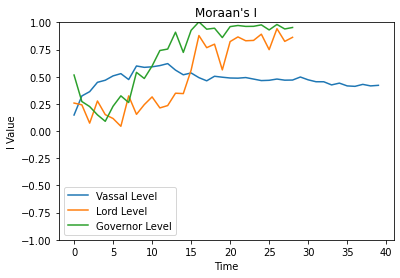

In [14]:
#main

# Simulate and plot results
nice_patterns = [6, 10, 7262]
init_pattern = input("Initial pattern?") # pattern for seed
sleep_time = 0.7
#steps_for_plot = 100
range_ = 40

vassal_moraans_plot_data = []
lord_moraans_plot_data = []
governor_moraans_plot_data = []

#print("Initializing...")
initialize(pattern=init_pattern, printy=False)
#print("Running simulation... Pattern:", init_pattern)
for time_step in range(40):

    # get moraans data
    vassal_I, lord_I, governor_I = update(printy=False)
    vassal_moraans_plot_data.append(round(vassal_I, 4))
    try:
        lord_moraans_plot_data.append(round(lord_I, 4))
    except TypeError:  # only 1 lord left
        pass
    try:
        governor_moraans_plot_data.append(round(governor_I, 4))
    except TypeError:  # only 1 governor left
        pass
    
    year = 800 + time_step*10
    print("Year: {} AD".format(year))
    update(printy=False)
    observe(ca_level="vassal", color_map="plasma")
    display.display(gcf())
    observe(ca_level="lord", color_map="plasma")
    display.display(gcf())
    observe(ca_level="governor", color_map="plasma")
    display.display(gcf())
    time.sleep(sleep_time)
    display.clear_output(wait=True) #comment for whole output
    plt.close()
plt.show()

axes = plt.gca()
axes.set_ylim([-1, 1])
time_axis_v = [num for num in range(len(vassal_moraans_plot_data))]
time_axis_l = [num for num in range(len(lord_moraans_plot_data))]
time_axis_g = [num for num in range(len(governor_moraans_plot_data))]
# plotting the points
plt.plot(time_axis_v, vassal_moraans_plot_data, label="Vassal Level")
plt.plot(time_axis_l, lord_moraans_plot_data, label="Lord Level")
plt.plot(time_axis_g, governor_moraans_plot_data, label="Governor Level")
plt.xlabel('Time')
# Set the y axis label of the current axis.
plt.ylabel('I Value')
# Set a title of the current axes.
plt.title("Moraan's I")
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()


